# Bayse Model 負の二項分布

In [3]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/configparser.py:316: UserWarning: PyTensor does not recognise this flag: blas_ldflags
  warnings.warn(f"PyTensor does not recognise this flag: {key}")


In [4]:
filepath = "../../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath).drop(columns=['special'])
df = df.dropna()

## Difine Variables

In [5]:
population = df['population']
bridge = df['dummy_after_bridge_opened']
income = df['income']
log_income = np.log(income)
area = df['area_km2']
log_area = np.log(area)
distance = df['distance_m']
log_distance = np.log(distance)

X = np.array([log_income, log_area, log_distance])

# 過分散パラメータ
mean_population = np.mean(population)
var_population = np.var(population)

alpha = (var_population - mean_population) / mean_population**2

In [6]:
bridge = np.array(bridge)
bridge[:, np.newaxis].shape

(830, 1)

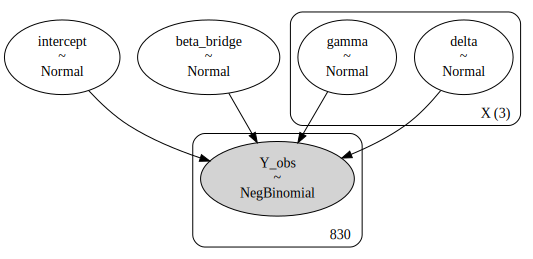

In [7]:
with pm.Model() as model:
    # 事前分布
    intercept = pm.Normal('intercept', mu=6.3, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0.5, sigma=100)
    gamma = pm.Normal('gamma', mu=0, sigma=100, shape=3, dims='X')
    delta = pm.Normal('delta', mu=0, sigma=100, shape=3, dims='X')

    # 交差項の計算
    interaction = bridge * X

    # 対数リンク関数
    lambda_ = pm.math.exp(intercept + beta_bridge * bridge + pm.math.dot(X.T, gamma) + pm.math.dot(interaction.T, delta))

    # 尤度
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lambda_, alpha=alpha, observed=population)


# モデルの視覚化
pm.model_to_graphviz(model)

In [9]:
with model:
    idata = pm.sample(
        draws=3000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [10]:
az.to_netcdf(idata, './bm_covariates_interactions.nc')

'./bm_covariates_interactions.nc'

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,6.262,0.106,6.064,6.456,0.001,0.001,6420.0,7262.0,1.0
beta_bridge,0.682,0.221,0.273,1.092,0.003,0.002,5689.0,6877.0,1.0
gamma[0],-0.061,0.008,-0.076,-0.046,0.000,0.000,7487.0,8089.0,1.0
gamma[1],0.906,0.010,0.887,0.925,0.000,0.000,7350.0,7548.0,1.0
gamma[2],-0.096,0.012,-0.118,-0.074,0.000,0.000,6688.0,7845.0,1.0
delta[0],0.171,0.017,0.140,0.203,0.000,0.000,7043.0,7563.0,1.0
delta[1],0.019,0.016,-0.012,0.049,0.000,0.000,7539.0,8732.0,1.0
delta[2],-0.241,0.027,-0.290,-0.190,0.000,0.000,6589.0,7654.0,1.0


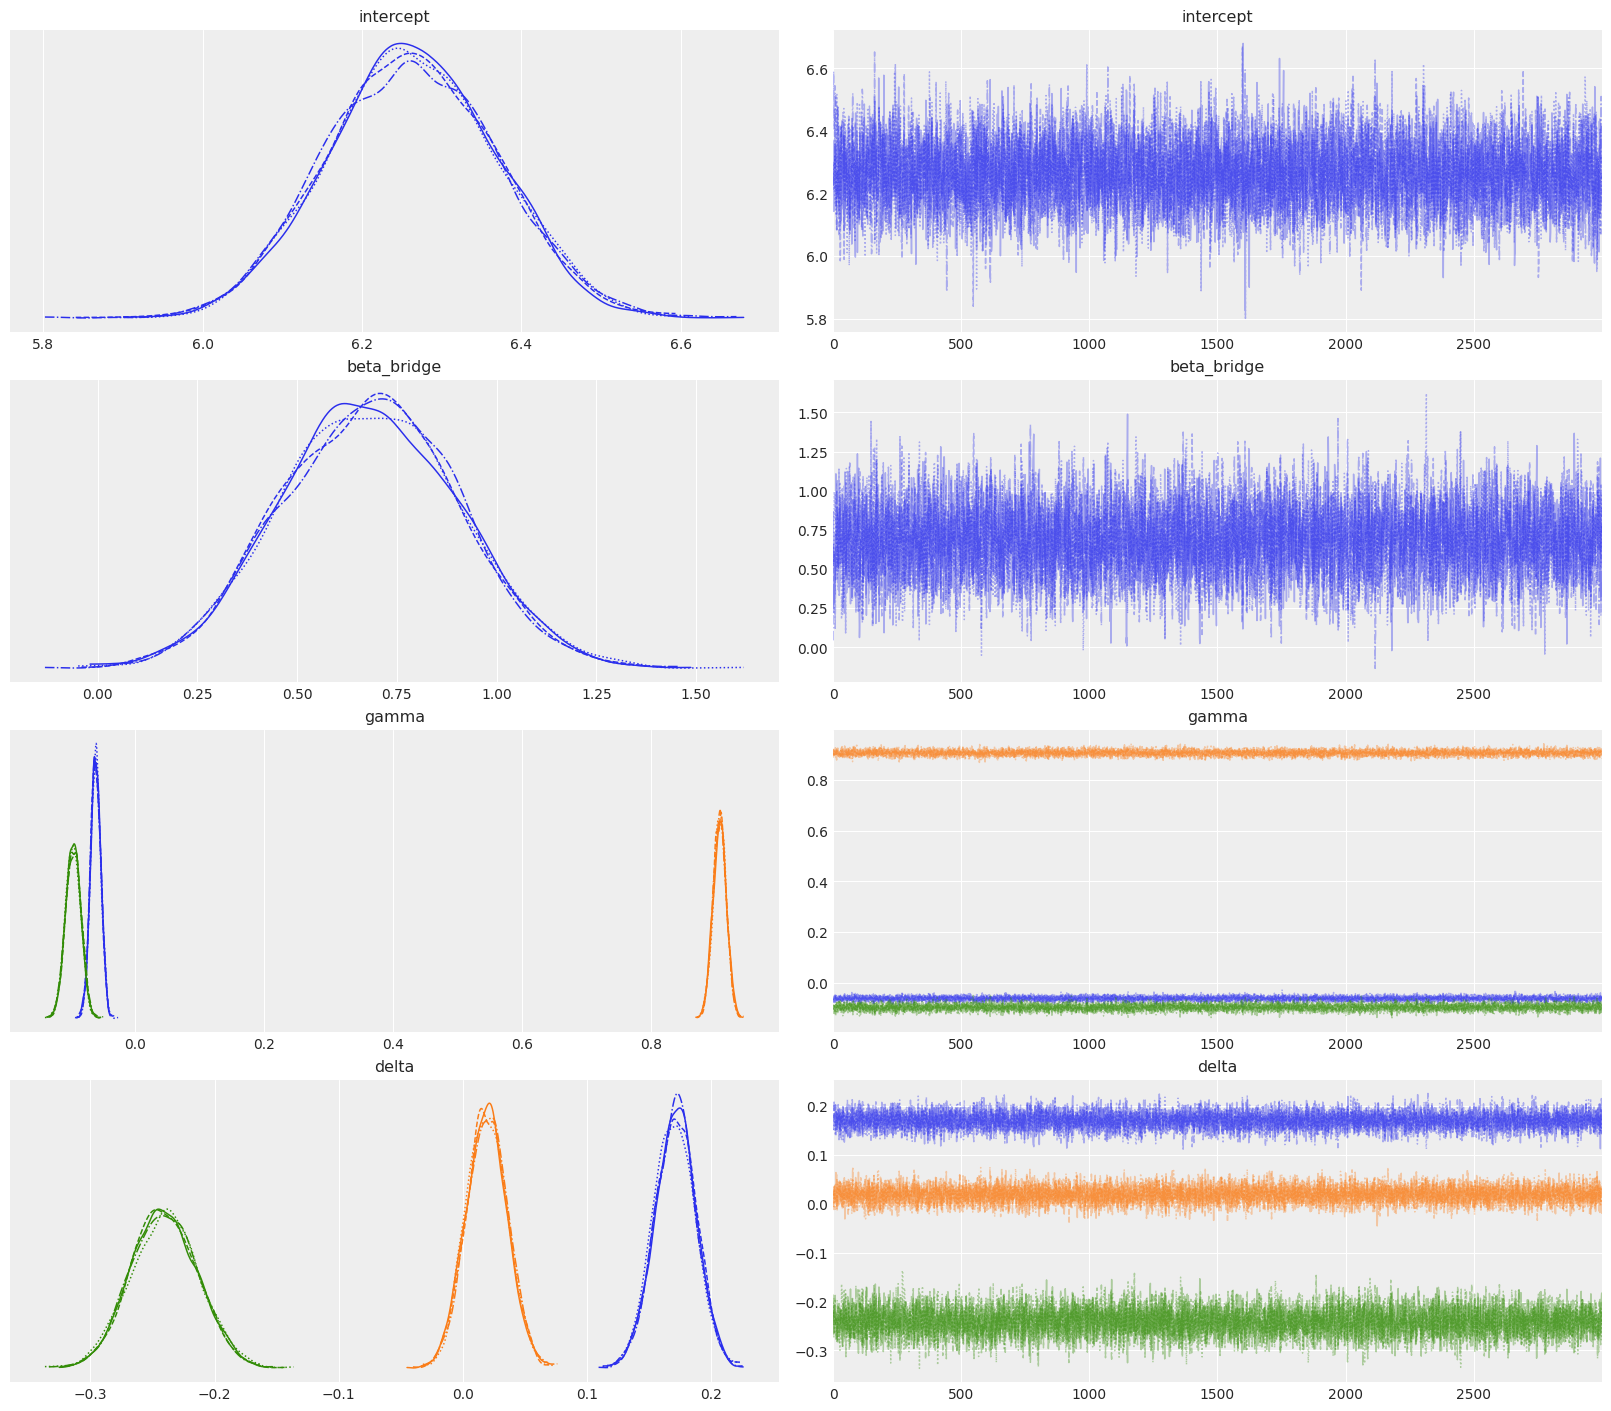

In [11]:
az.plot_trace(idata, figsize=(16, 14))  # サイズを調整
az.summary(idata)

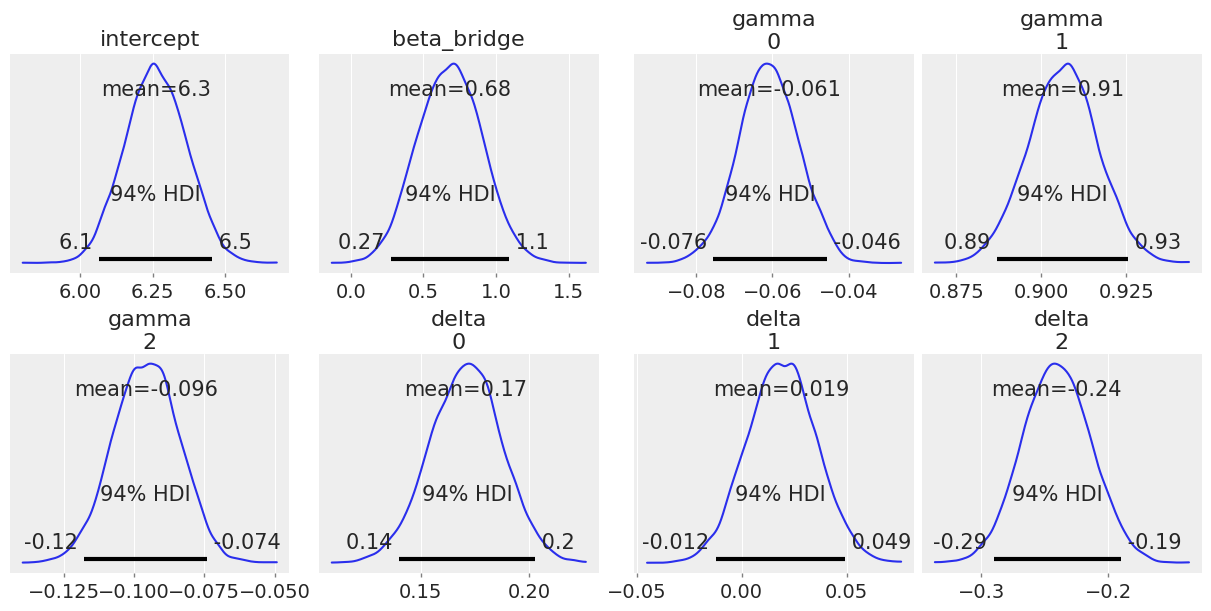

In [20]:
az.plot_posterior(idata, var_names=['intercept', 'beta_bridge', 'gamma', 'delta'], figsize=(12, 6));

# パラメータが0以上である確率

In [21]:
posterior_samples = idata.posterior

intercept_samples = posterior_samples['intercept']
beta_bridge_samples = posterior_samples['beta_bridge']
gamma_income_samples = posterior_samples['gamma'][:, :, 0]
gamma_area_samples = posterior_samples['gamma'][:, :, 1]
gamma_distance_samples = posterior_samples['gamma'][:, :, 2]
delta_income_samples = posterior_samples['delta'][:, :, 0]
delta_area_samples = posterior_samples['delta'][:, :, 1]
delta_distance_samples = posterior_samples['delta'][:, :, 2]


# 0以上のサンプルの割合を計算
prob_beta_intercept_positive = np.mean(intercept_samples > 0)
prob_beta_bridge_positive = np.mean(beta_bridge_samples > 0)
prob_gamma_income_positive = np.mean(gamma_income_samples > 0)
prob_gamma_area_positive = np.mean(gamma_area_samples > 0)
prob_gamma_distance_positive = np.mean(gamma_distance_samples > 0)
prog_delta_income_positive = np.mean(delta_income_samples > 0)
prog_delta_area_positive = np.mean(delta_area_samples > 0)
prog_delta_distance_positive = np.mean(delta_distance_samples > 0)

print(f"Pr(intercept > 0) = {prob_beta_intercept_positive:.4f}")
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
print(f"Pr(gamma_income > 0) = {prob_gamma_income_positive:.4f}")
print(f"Pr(gamma_area > 0) = {prob_gamma_area_positive:.4f}")
print(f"Pr(gamma_distance > 0) = {prob_gamma_distance_positive:.4f}")
print(f"Pr(delta_income > 0) = {prog_delta_income_positive:.4f}")
print(f"Pr(delta_area > 0) = {prog_delta_area_positive:.4f}")
print(f"Pr(delta_distance > 0) = {prog_delta_distance_positive:.4f}")

Pr(intercept > 0) = 1.0000
Pr(beta_bridge > 0) = 0.9996
Pr(gamma_income > 0) = 0.0000
Pr(gamma_area > 0) = 1.0000
Pr(gamma_distance > 0) = 0.0000
Pr(delta_income > 0) = 1.0000
Pr(delta_area > 0) = 0.8738
Pr(delta_distance > 0) = 0.0000


In [14]:
with model:
    pm.compute_log_likelihood(idata)

Output()

In [15]:
loo = az.loo(idata)
loo

Computed from 12000 posterior samples and 830 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -7811.50   161.38
p_loo       58.90        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      830  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%